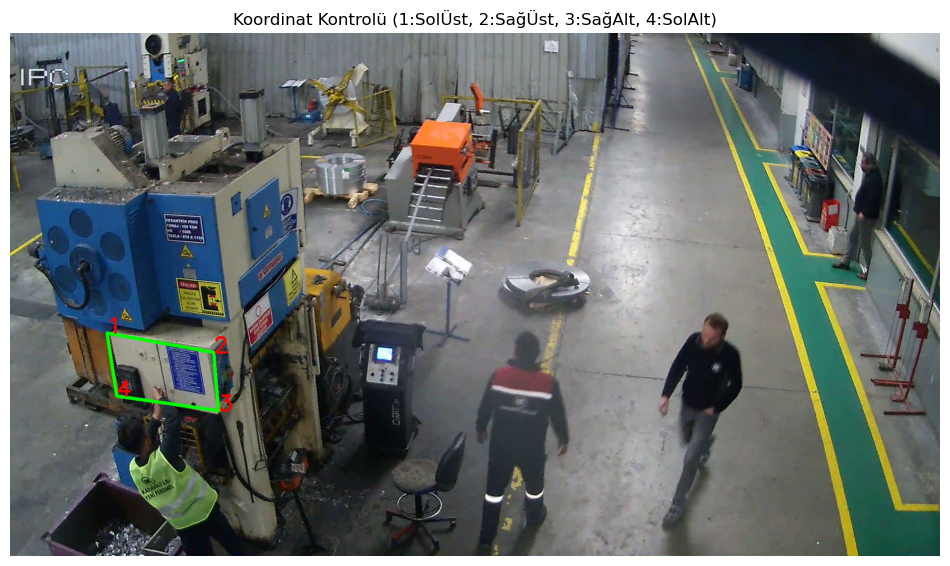

In [25]:
import zipfile
import tempfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- AYARLAR ---
zip_path = r"c:\Users\User\Desktop\fabrika\fab.zip"
member = "Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te1.mp4"

# Buradaki sayıları değiştirerek deneme yap: [x, y]
# Sıralama: Sol-Üst, Sağ-Üst, Sağ-Alt, Sol-Alt
PANO_PTS = np.array([
    [200, 620],  # Sol Üst
    [420, 660],  # Sağ Üst
    [430, 780],  # Sağ Alt
    [220, 750]   # Sol Alt
], np.int32)

# 1. Videodan bir kareyi belleğe al
with zipfile.ZipFile(zip_path) as z:
    data = z.read(member)
    with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmp:
        tmp.write(data)
        tmp_path = tmp.name

cap = cv2.VideoCapture(tmp_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 30) # 30. kareyi görelim (pano netleşsin)
ret, frame = cap.read()
cap.release()
os.remove(tmp_path)

if ret:
    # 2. Koordinatları görsel üzerine çiz (Kontrol için)
    # Noktaları birleştirerek bir çokgen (polygon) çiziyoruz
    frame_vis = frame.copy()
    cv2.polylines(frame_vis, [PANO_PTS.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=5)
    
    # Köşelere numara yazalım (sıralamayı karıştırmamak için)
    for i, pt in enumerate(PANO_PTS):
        cv2.putText(frame_vis, str(i+1), tuple(pt), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

    # 3. Sonucu Göster
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
    plt.title("Koordinat Kontrolü (1:SolÜst, 2:SağÜst, 3:SağAlt, 4:SolAlt)")
    plt.axis('off')
    plt.show()
else:
    print("Video karesi okunamadı, yolu kontrol et.")

In [28]:
import cv2
import numpy as np
import os
import zipfile
import tempfile
from pathlib import Path

# --- AYARLAR ---
ZIP_PATH = r"c:\Users\User\Desktop\fabrika\fab.zip"
# Masaüstü yolunu otomatik bulur
DESKTOP_PATH = os.path.join(os.path.expanduser("~"), "Desktop")
OUTPUT_DIR = r"C:\Users\User\Desktop\acik"
# Senin belirlediğin koordinatlar
PANO_PTS = np.float32([
    [200, 620],  # Sol Üst
    [420, 660],  # Sağ Üst
    [430, 780],  # Sağ Alt
    [220, 750]   # Sol Alt
])

# Çıktı klasörünü oluştur
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TARGET_SIZE = (224, 224) # Model eğitimi için standart kare boyut

def get_perspective_crop(img, src_pts, size):
    """4 noktayı alıp düzelterek (birds-eye view) kırpar."""
    dst_pts = np.float32([[0, 0], [size[0], 0], [size[0], size[1]], [0, size[1]]])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return cv2.warpPerspective(img, matrix, size)

def process_open_panels():
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        # Sadece '2_opened_panel cover' klasöründeki mp4'leri al
        target_folder = "2_opened_panel cover"
        video_files = [f for f in z.namelist() if f.endswith('.mp4') and target_folder in f]
        
        if not video_files:
            print(f"Hata: '{target_folder}' klasöründe video bulunamadı!")
            return

        for video_path in video_files:
            print(f"İşleniyor: {video_path}")
            
            # Videoyu geçici dosyaya çıkar
            video_data = z.read(video_path)
            with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmp:
                tmp.write(video_data)
                tmp_name = tmp.name

            cap = cv2.VideoCapture(tmp_name)
            video_stem = Path(video_path).stem
            frame_idx = 0
            saved_count = 0
            
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Her 15 karede bir örnek al (Çok fazla aynı resim olmaması için)
                # Eğer tüm kareleri istiyorsan bu if satırını kaldırabilirsin.
                if frame_idx % 15 == 0:
                    cropped = get_perspective_crop(frame, PANO_PTS, TARGET_SIZE)
                    
                    # Dosya adı: videoadi_f0.jpg, videoadi_f15.jpg şeklinde gider
                    filename = f"{video_stem}_f{frame_idx}.jpg"
                    cv2.imwrite(os.path.join(OUTPUT_DIR, filename), cropped)
                    saved_count += 1
                
                frame_idx += 1
            
            cap.release()
            os.remove(tmp_name)
            print(f"Bitti: {video_stem} videosundan {saved_count} kare kaydedildi.")

# --- ÇALIŞTIR ---
if __name__ == "__main__":
    process_open_panels()
    print(f"\n✅ İşlem tamam! Resimler burada: {OUTPUT_DIR}")

İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te1.mp4
Bitti: 2_te1 videosundan 7 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te2.mp4
Bitti: 2_te2 videosundan 9 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te4.mp4
Bitti: 2_te4 videosundan 9 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te3.mp4
Bitti: 2_te3 videosundan 9 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te5.mp4
Bitti: 2_te5 videosundan 10 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/2_opened_panel cover/2_te12.mp4
Bitti: 2_te12 vi

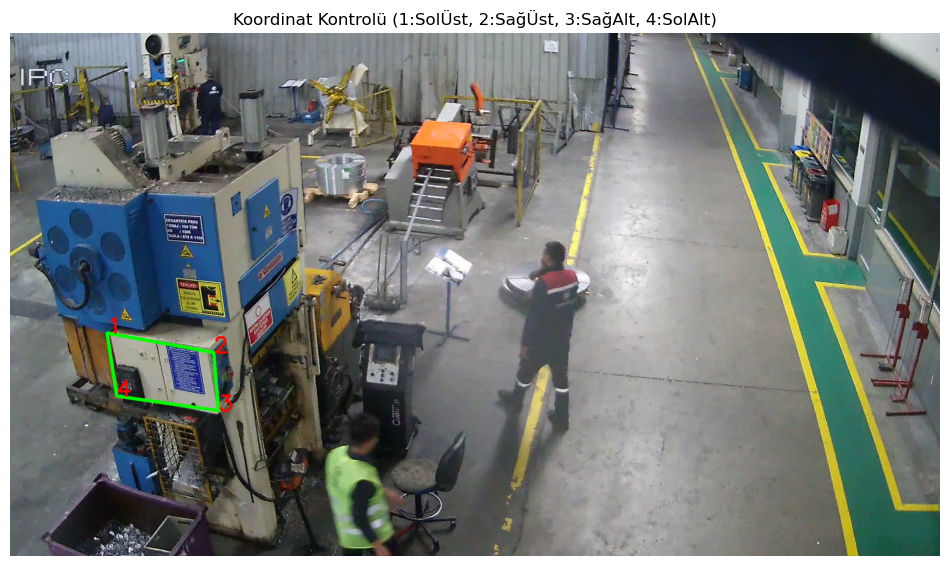

In [31]:
import zipfile
import tempfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- AYARLAR ---
zip_path = r"c:\Users\User\Desktop\fabrika\fab.zip"
# Düzeltildi: doğru dosya yolu (train klasöründeki 6_tr1.mp4)
member = "Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/train/6_closed_panel_cover/6_tr1.mp4"

# Buradaki sayıları değiştirerek deneme yap: [x, y]
# Sıralama: Sol-Üst, Sağ-Üst, Sağ-Alt, Sol-Alt
PANO_PTS = np.array([
    [200, 620],  # Sol Üst
    [420, 660],  # Sağ Üst
    [430, 780],  # Sağ Alt
    [220, 750]   # Sol Alt
], np.int32)

# 1. Videodan bir kareyi belleğe al
with zipfile.ZipFile(zip_path) as z:
    data = z.read(member)
    with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmp:
        tmp.write(data)
        tmp_path = tmp.name

cap = cv2.VideoCapture(tmp_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 30) # 30. kareyi görelim (pano netleşsin)
ret, frame = cap.read()
cap.release()
os.remove(tmp_path)

if ret:
    # 2. Koordinatları görsel üzerine çiz (Kontrol için)
    # Noktaları birleştirerek bir çokgen (polygon) çiziyoruz
    frame_vis = frame.copy()
    cv2.polylines(frame_vis, [PANO_PTS.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=5)
    
    # Köşelere numara yazalım (sıralamayı karıştırmamak için)
    for i, pt in enumerate(PANO_PTS):
        cv2.putText(frame_vis, str(i+1), tuple(pt), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

    # 3. Sonucu Göster
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
    plt.title("Koordinat Kontrolü (1:SolÜst, 2:SağÜst, 3:SağAlt, 4:SolAlt)")
    plt.axis('off')
    plt.show()
else:
    print("Video karesi okunamadı, yolu kontrol et.")


In [ ]:
import cv2
import numpy as np
import os
import zipfile
import tempfile
from pathlib import Path

# --- AYARLAR ---
ZIP_PATH = r"c:\Users\User\Desktop\fabrika\fab.zip"
# Masaüstü yolunu otomatik bulur
DESKTOP_PATH = os.path.join(os.path.expanduser("~"), "Desktop")
OUTPUT_DIR = r"C:\Users\User\Desktop\kapali"
# Senin belirlediğin koordinatlar
PANO_PTS = np.float32([
    [200, 620],  # Sol Üst
    [420, 660],  # Sağ Üst
    [430, 780],  # Sağ Alt
    [220, 750]   # Sol Alt
])

# Çıktı klasörünü oluştur
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TARGET_SIZE = (224, 224) # Model eğitimi için standart kare boyut

def get_perspective_crop(img, src_pts, size):
    """4 noktayı alıp düzelterek (birds-eye view) kırpar."""
    dst_pts = np.float32([[0, 0], [size[0], 0], [size[0], size[1]], [0, size[1]]])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return cv2.warpPerspective(img, matrix, size)

def process_closed_panels():
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        # Sadece '6_closed_panel_cover' klasöründeki mp4'leri al
        target_folder = "6_closed_panel_cover"
        video_files = [f for f in z.namelist() if f.endswith('.mp4') and target_folder in f]
        
        if not video_files:
            print(f"Hata: '{target_folder}' klasöründe video bulunamadı!")
            return

        for video_path in video_files:
            print(f"İşleniyor: {video_path}")
            
            # Videoyu geçici dosyaya çıkar
            video_data = z.read(video_path)
            with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmp:
                tmp.write(video_data)
                tmp_name = tmp.name

            cap = cv2.VideoCapture(tmp_name)
            video_stem = Path(video_path).stem
            frame_idx = 0
            saved_count = 0
            
            while True:
                ret, fr ame = cap.read()
                if not ret:
                    break
                
                # Her 15 karede bir örnek al (Çok fazla aynı resim olmaması için)
                # Eğer tüm kareleri istiyorsan bu if satırını kaldırabilirsin.
                if frame_idx % 15 == 0:
                    cropped = get_perspective_crop(frame, PANO_PTS, TARGET_SIZE)
                    
                    # Dosya adı: videoadi_f0.jpg, videoadi_f15.jpg şeklinde gider
                    filename = f"{video_stem}_f{frame_idx}.jpg"
                    cv2.imwrite(os.path.join(OUTPUT_DIR, filename), cropped)
                    saved_count += 1
                
                frame_idx += 1
            
            cap.release()
            os.remove(tmp_name)
            print(f"Bitti: {video_stem} videosundan {saved_count} kare kaydedildi.")

# --- ÇALIŞTIR ---
if __name__ == "__main__":
    process_closed_panels()
    print(f"\n✅ İşlem tamam! Resimler burada: {OUTPUT_DIR}")

İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te10.mp4
Bitti: 6_te10 videosundan 4 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te7.mp4
Bitti: 6_te7 videosundan 6 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te4.mp4
Bitti: 6_te4 videosundan 7 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te3.mp4
Bitti: 6_te3 videosundan 7 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te5.mp4
Bitti: 6_te5 videosundan 7 kare kaydedildi.
İşleniyor: Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/test/6_closed_panel_cover/6_te6.mp4
Bitti: 6_te6 vid

In [36]:
import cv2
import os
import numpy as np
import random

# --- YOLLARI KONTROL ET ---
# Eğer 'kapalı' ismi sorun çıkarıyorsa, klasörün adını 'kapali' yapıp burayı da güncelle.
input_dir = r"C:\Users\User\Desktop\fabrika\kapali"
output_dir = r"C:\Users\User\Desktop\fabrika\kapali_yeni"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def augment_image(img):
    aug_images = []
    # 1. Yatay Aynalama
    aug_images.append(cv2.flip(img, 1))
    
    # 2. Parlaklık
    value = random.uniform(0.7, 1.3)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * value
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    aug_images.append(cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR))
    
    # 3. Hafif Döndürme
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), random.uniform(-5, 5), 1.0)
    aug_images.append(cv2.warpAffine(img, M, (w, h)))
    
    return aug_images

# Resimleri listele
files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Bulunan dosya sayısı: {len(files)}")

if len(files) == 0:
    print("HATA: Klasör boş veya yol yanlış! Lütfen klasör adını kontrol et.")
else:
    for img_name in files:
        full_path = os.path.join(input_dir, img_name)
        # OpenCV bazen Türkçe yolları okuyamaz, bu yüzden imread yerine alternatif:
        img = cv2.imdecode(np.fromfile(full_path, dtype=np.uint8), cv2.IMREAD_COLOR)
        
        if img is None:
            print(f"Atlanıyor (Okunamadı): {img_name}")
            continue
            
        # Orijinali kaydet
        cv2.imwrite(os.path.join(output_dir, img_name), img)
        
        # Artırılmışları kaydet
        for i, aug in enumerate(augment_image(img)):
            cv2.imwrite(os.path.join(output_dir, f"aug_{i}_{img_name}"), aug)

print(f"BİTTİ! Toplam resim sayısı: {len(os.listdir(output_dir))}")

Bulunan dosya sayısı: 279
BİTTİ! Toplam resim sayısı: 1116
